# Kaggle Diabetes Dataset Analysis

This notebook analyzes the Kaggle Diabetes dataset to create an interpretable prediction model with explanations for healthcare workers.

## 1. Setup and Imports

In [37]:
import sys
import os
sys.path.append(os.path.abspath('../'))

import pandas as pd
import matplotlib.pyplot as plt
import warnings
import json
from pathlib import Path

from scripts.utils import *

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

MODEL_DIR = "../models"
MODEL_NAME = "kaggle_diabetes"
FORCE_RETRAIN = False  # Set to True to force retraining of all models

Path(MODEL_DIR).mkdir(parents=True, exist_ok=True)

## 2. Load Kaggle Diabetes Dataset

In [38]:
kaggle_df = load_dataset("../data/kaggle_dataset.csv", dataset_type="kaggle")
kaggle_df.head()

Loaded kaggle dataset with shape: (100000, 9)


,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


### Data Description

The Kaggle Diabetes dataset contains patient records with various health indicators. Key variables include:

- **gender**: Patient's gender (Female/Male/Other)
- **age**: Patient's age in years
- **hypertension**: Hypertension status (0 = no, 1 = yes)
- **heart_disease**: Heart disease status (0 = no, 1 = yes)
- **smoking_history**: Smoking status (categories including 'never', 'former', 'current', etc.)
- **bmi**: Body Mass Index
- **HbA1c_level**: Hemoglobin A1c level
- **blood_glucose_level**: Blood glucose level
- **diabetes**: Diabetes status (0 = no, 1 = yes, the target variable)

## 3. Exploratory Data Analysis (EDA)

Dataset shape: (100000, 9)

--- Basic Statistics ---
                 age  hypertension  heart_disease            bmi  \
count  100000.000000  100000.00000  100000.000000  100000.000000   
mean       41.885856       0.07485       0.039420      27.320767   
std        22.516840       0.26315       0.194593       6.636783   
min         0.080000       0.00000       0.000000      10.010000   
25%        24.000000       0.00000       0.000000      23.630000   
50%        43.000000       0.00000       0.000000      27.320000   
75%        60.000000       0.00000       0.000000      29.580000   
max        80.000000       1.00000       1.000000      95.690000   

         HbA1c_level  blood_glucose_level       diabetes  
count  100000.000000        100000.000000  100000.000000  
mean        5.527507           138.058060       0.085000  
std         1.070672            40.708136       0.278883  
min         3.500000            80.000000       0.000000  
25%         4.800000           100.0000

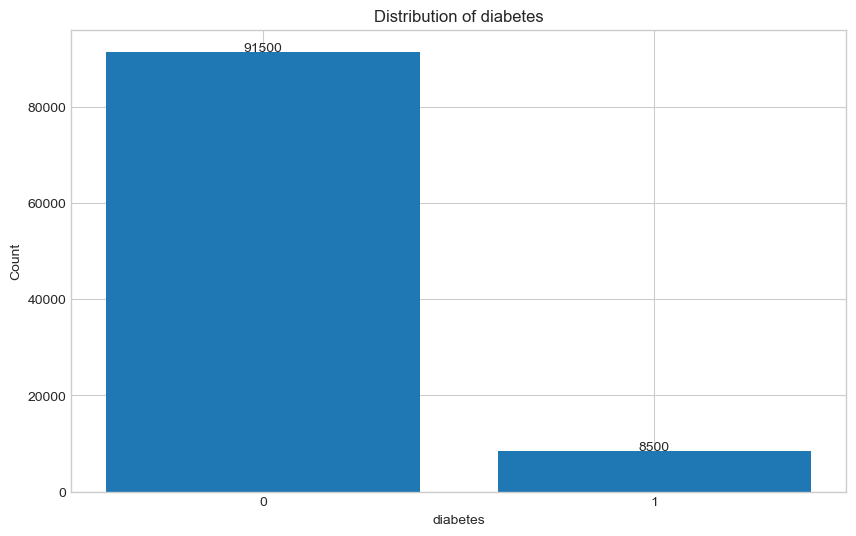


Class imbalance ratio: 10.76:1


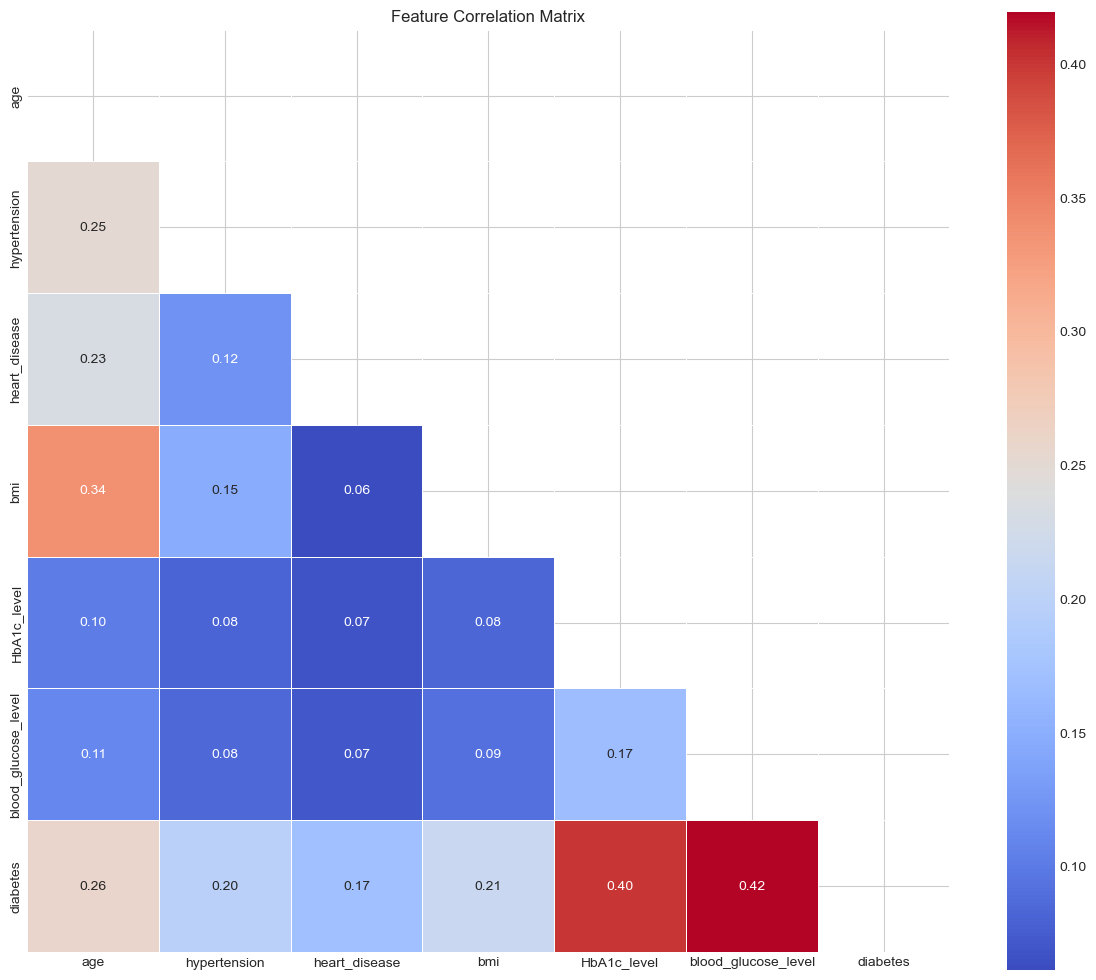

In [39]:
perform_eda(kaggle_df, target='diabetes')

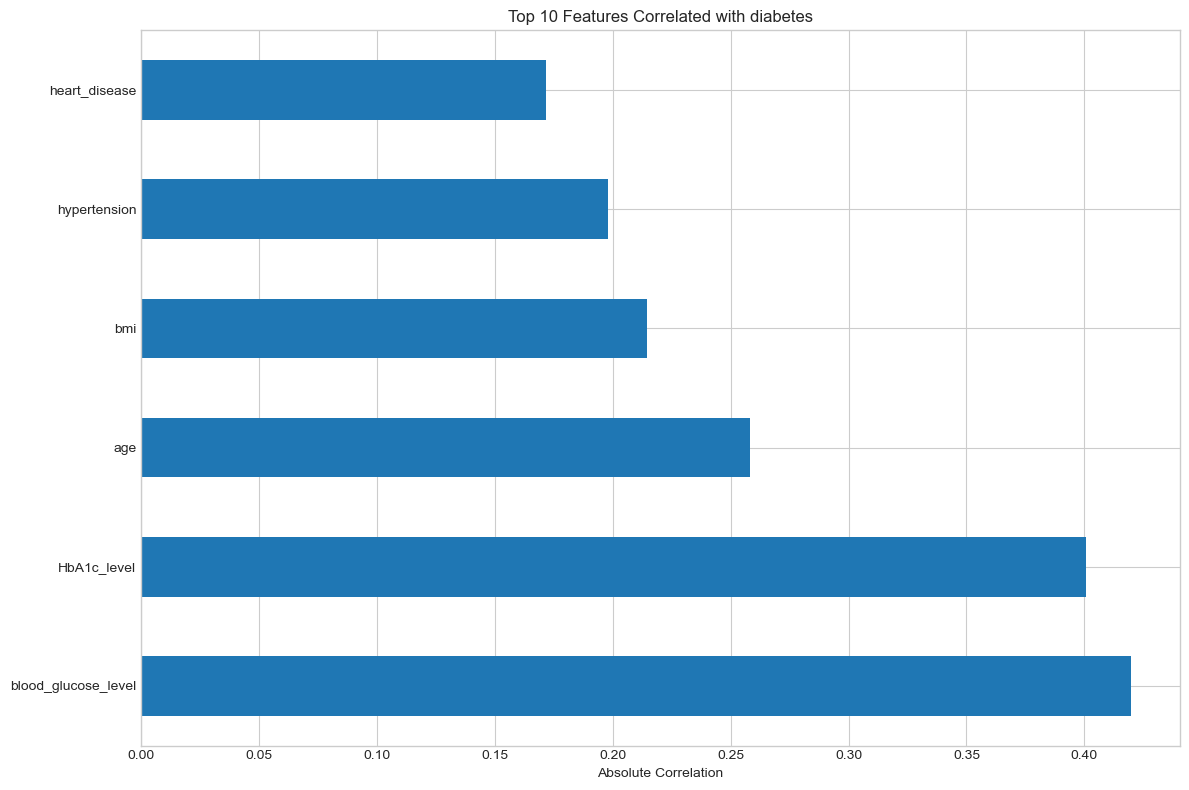

In [40]:
plot_feature_importance_to_target(kaggle_df, target='diabetes', top_n=10)

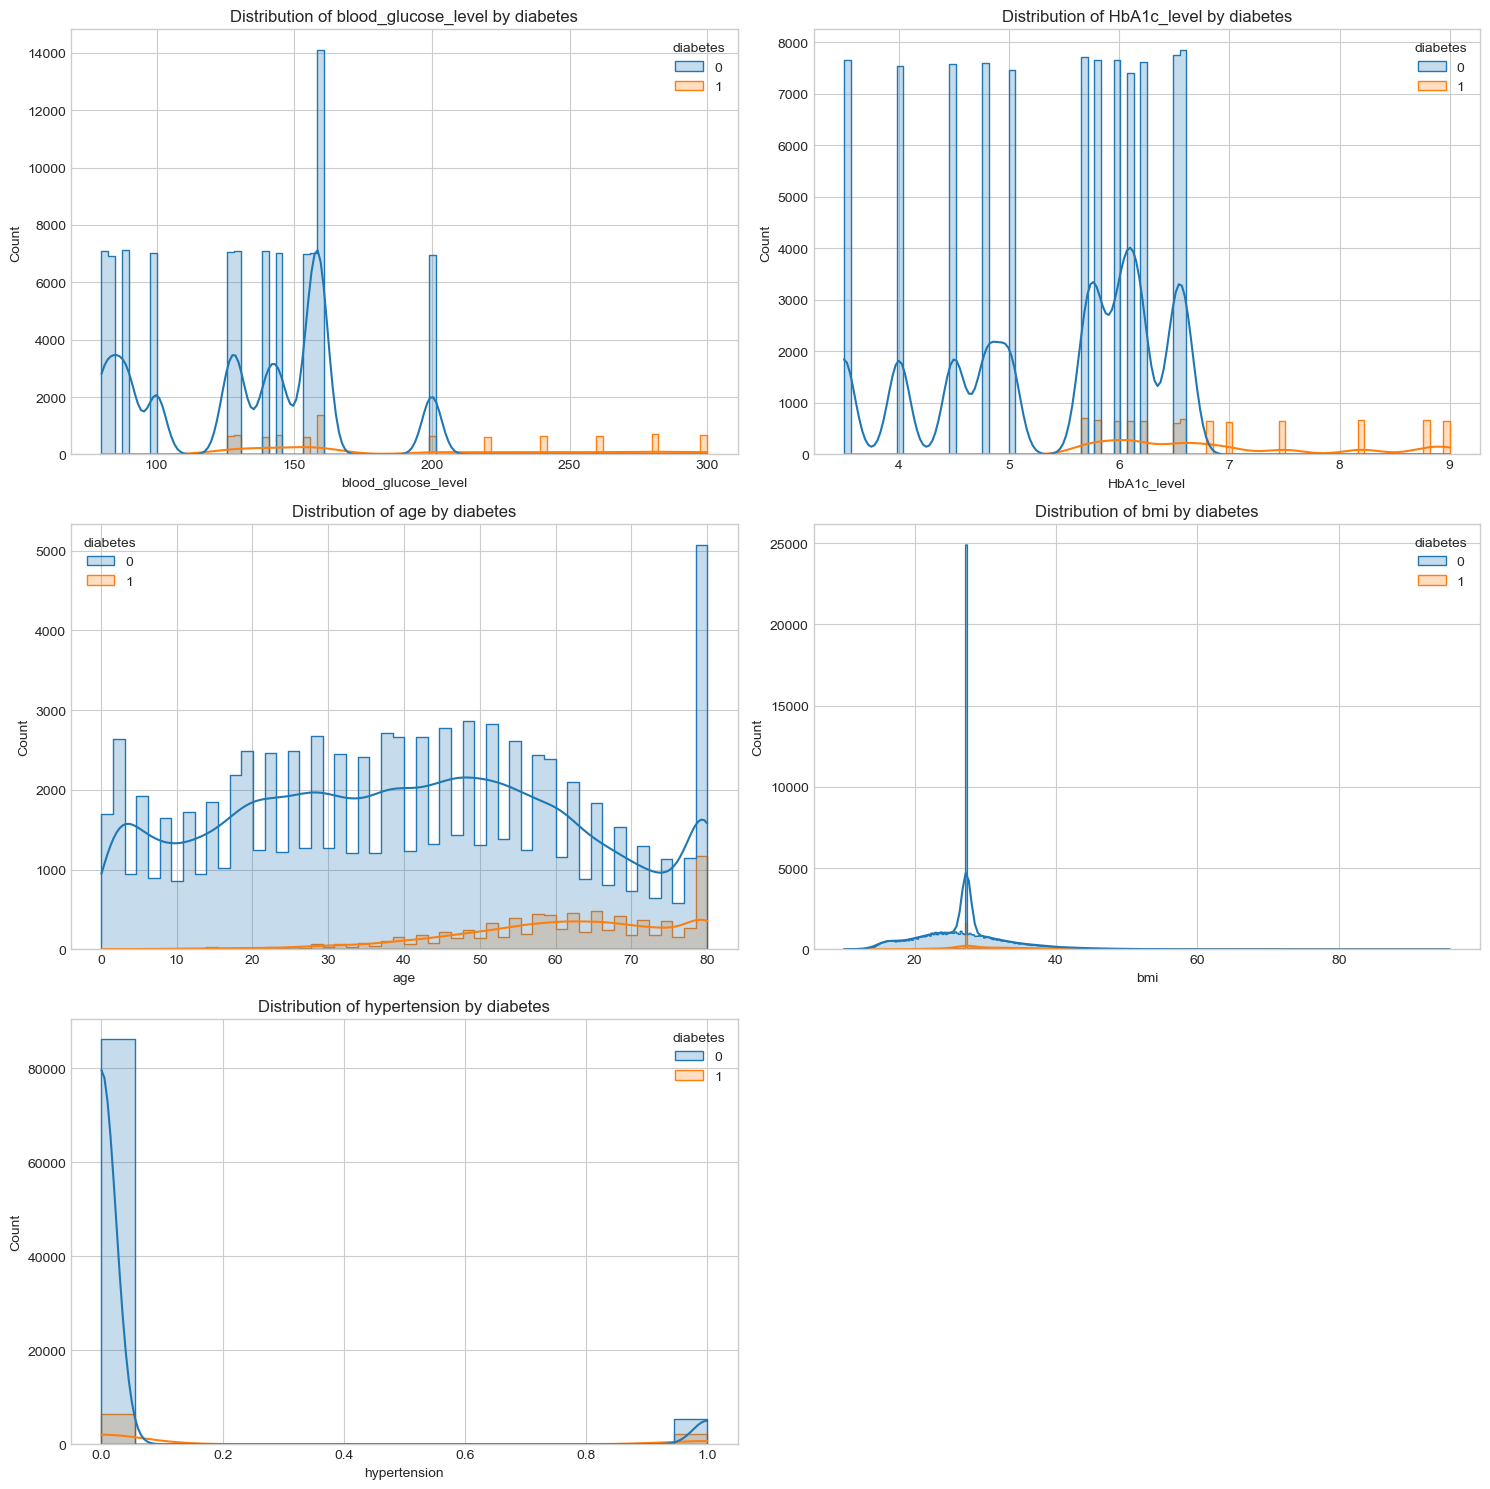

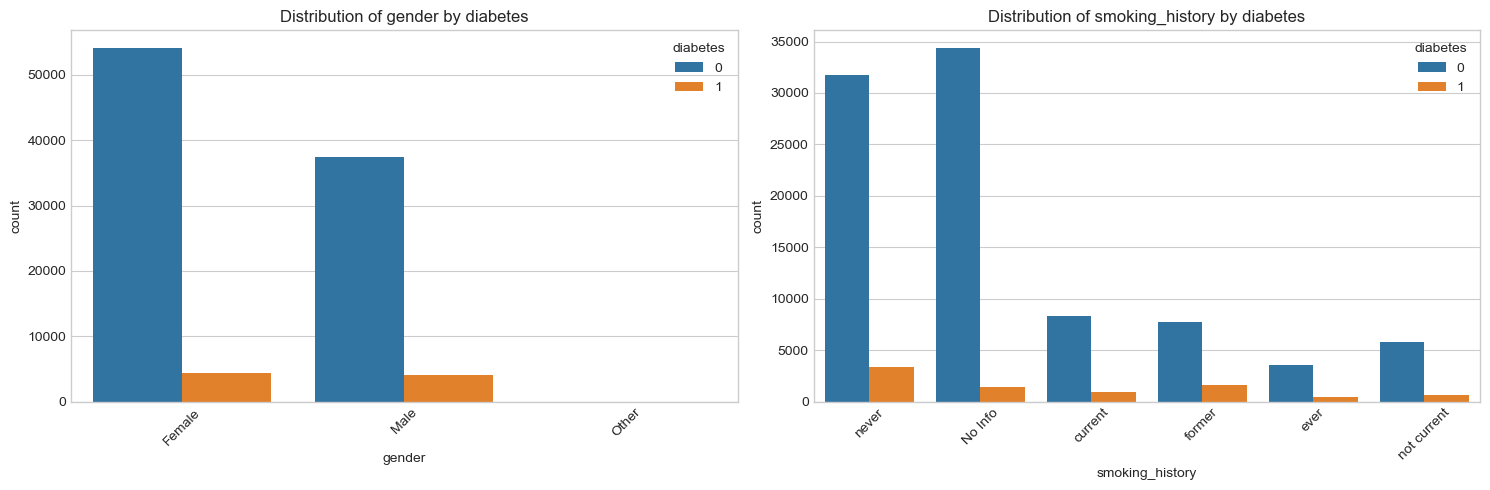

In [41]:
numeric_cols = kaggle_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_cols.remove('diabetes')
correlations = kaggle_df[numeric_cols].corrwith(kaggle_df['diabetes']).abs().sort_values(ascending=False)
top_numeric_features = correlations.head(5).index.tolist()

plot_distributions_by_target(kaggle_df, target='diabetes', num_features=top_numeric_features)

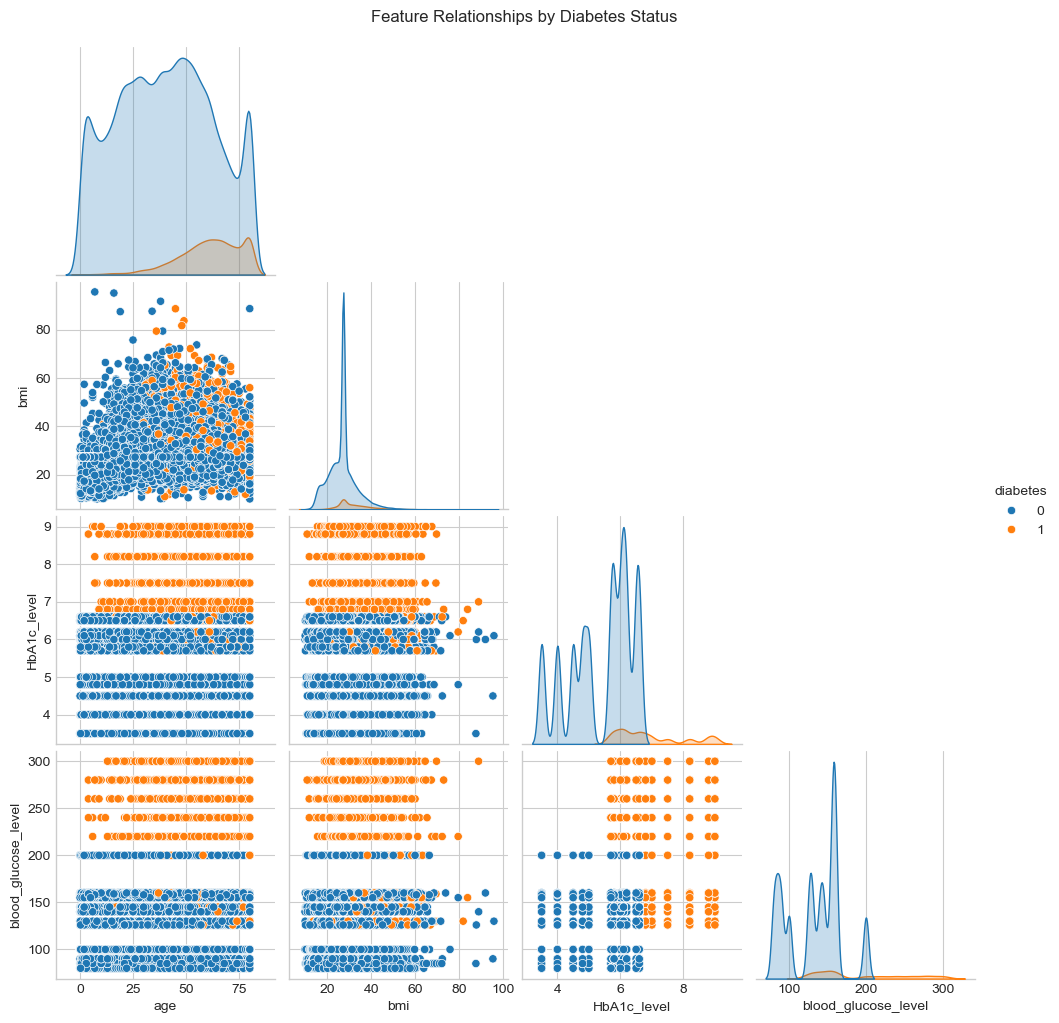

In [42]:
create_feature_pairplot(kaggle_df, target='diabetes', features=['age', 'bmi', 'HbA1c_level', 'blood_glucose_level'])

## 4. Data Preprocessing

In [43]:
X = kaggle_df.drop('diabetes', axis=1)
y = kaggle_df['diabetes']

X_train, X_test, y_train, y_test = split_data(X, y, test_size=0.2, random_state=42, stratify=y)

Splitting data with test_size=0.2
Training set: (80000, 8), Test set: (20000, 8)
Class distribution in training set: {np.int64(0): np.int64(73200), np.int64(1): np.int64(6800)}
Class distribution in test set: {np.int64(0): np.int64(18300), np.int64(1): np.int64(1700)}


In [44]:
preprocessor_path = Path(MODEL_DIR) / f"{MODEL_NAME}_preprocessor.pkl"
if preprocessor_path.exists() and not FORCE_RETRAIN:
    print(f"Loading existing preprocessor from {preprocessor_path}...")
    preprocessor = joblib.load(preprocessor_path)
    feature_info_path = Path(MODEL_DIR) / f"{MODEL_NAME}_feature_info.pkl"
    with open(feature_info_path, 'rb') as f:
        feature_info = pickle.load(f)
    num_features = feature_info['num_features']
    cat_features = feature_info['cat_features']
    feature_names = feature_info['feature_names']
else:
    print("Building and fitting preprocessor...")
    preprocessor, num_features, cat_features = build_preprocessing_pipeline(X)
    X_train_processed = preprocessor.fit_transform(X_train)
    feature_names = get_feature_names(preprocessor, num_features, cat_features)
    
    joblib.dump(preprocessor, preprocessor_path)
    feature_info = {
        'feature_names': feature_names,
        'num_features': num_features,
        'cat_features': cat_features
    }
    with open(Path(MODEL_DIR) / f"{MODEL_NAME}_feature_info.pkl", 'wb') as f:
        pickle.dump(feature_info, f)

X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print(f"Total processed features: {len(feature_names)}")

Loading existing preprocessor from ..\models\kaggle_diabetes_preprocessor.pkl...
Total processed features: 15


## 5. Model Training and Evaluation


=== Decision Tree Model ===
Loading existing decision_tree model from ..\models\kaggle_diabetes_decision_tree_model.pkl...
Model loaded successfully!


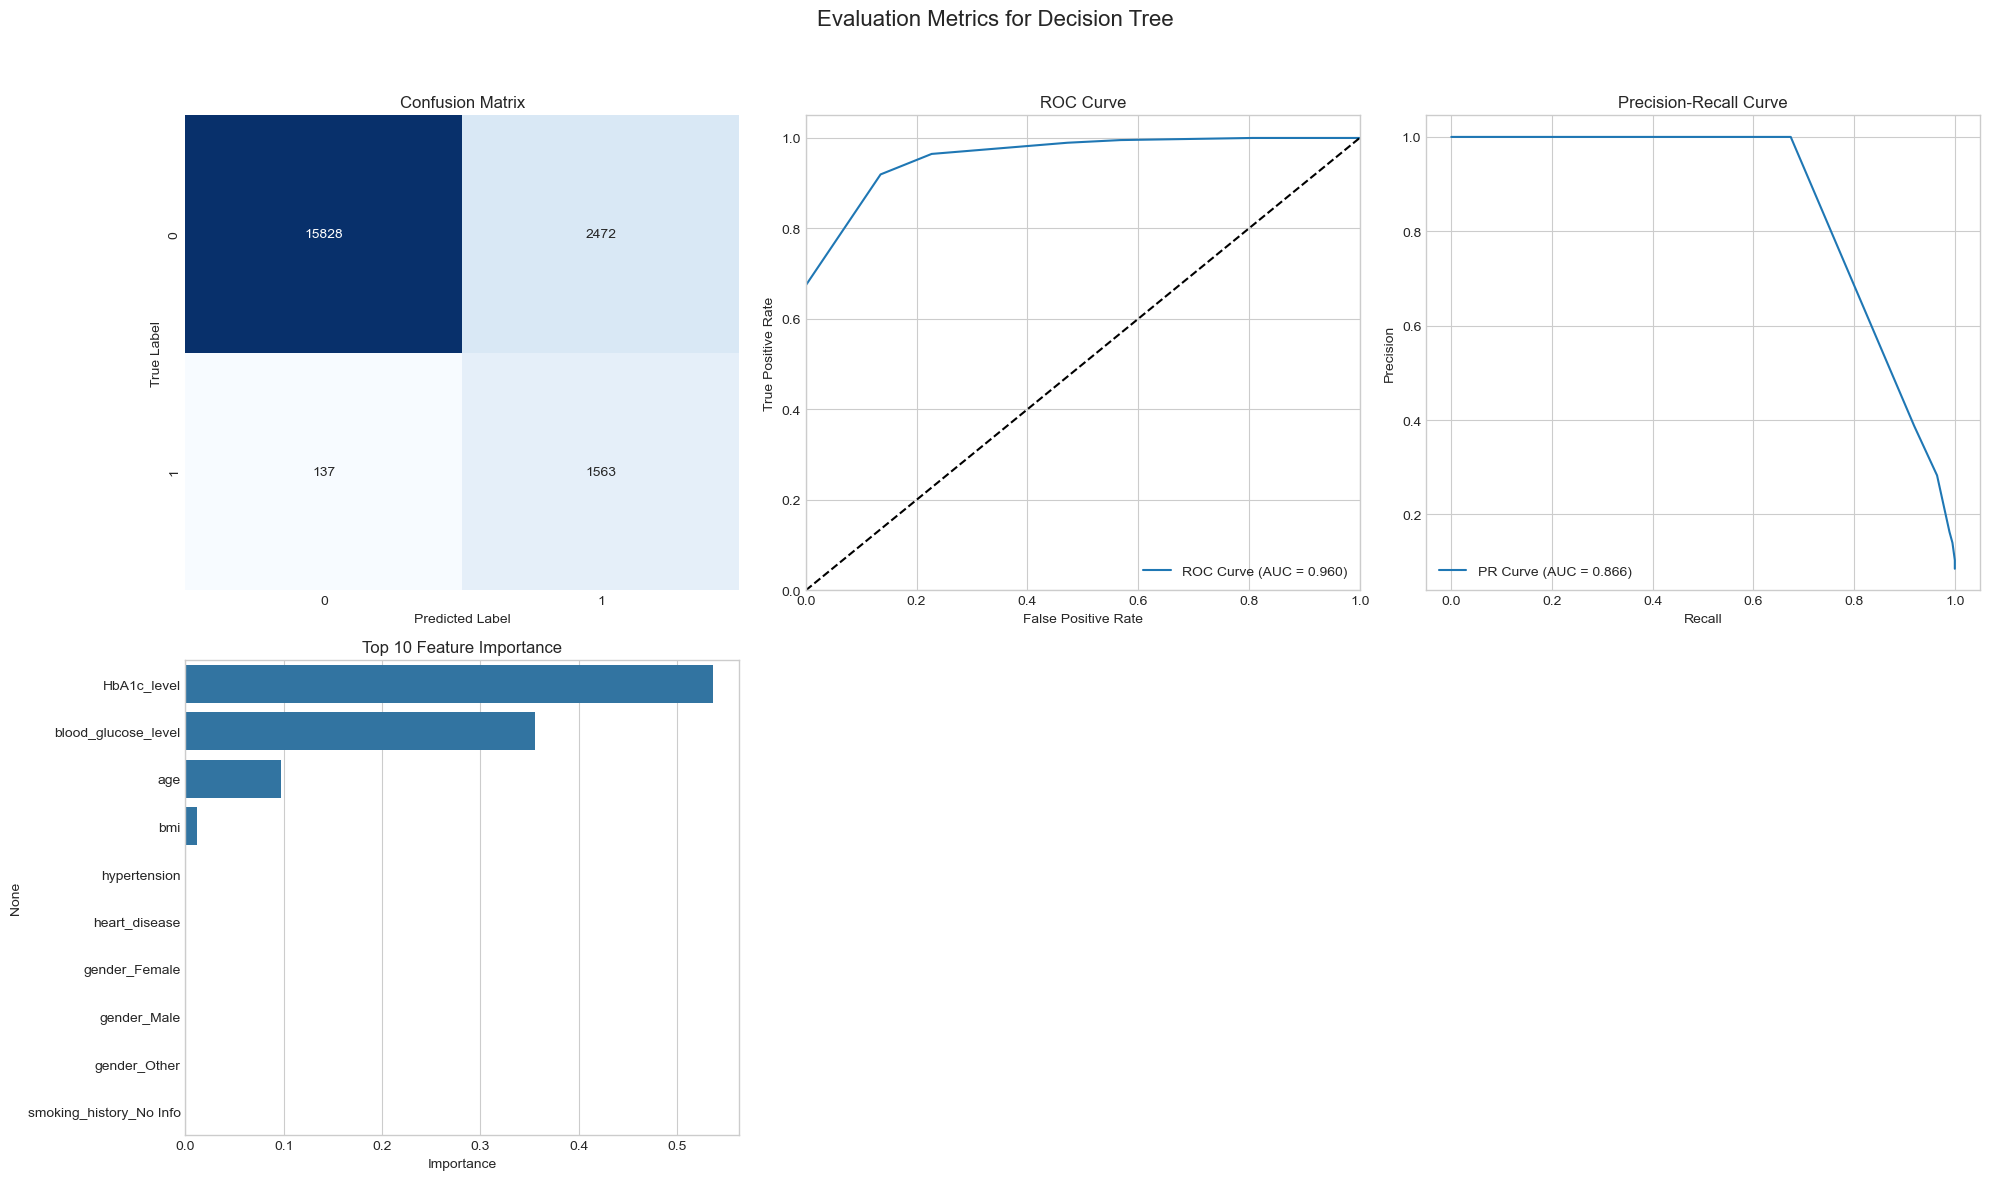


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.86      0.92     18300
           1       0.39      0.92      0.55      1700

    accuracy                           0.87     20000
   macro avg       0.69      0.89      0.73     20000
weighted avg       0.94      0.87      0.89     20000


=== Random Forest Model ===
Loading existing random_forest model from ..\models\kaggle_diabetes_random_forest_model.pkl...
Model loaded successfully!


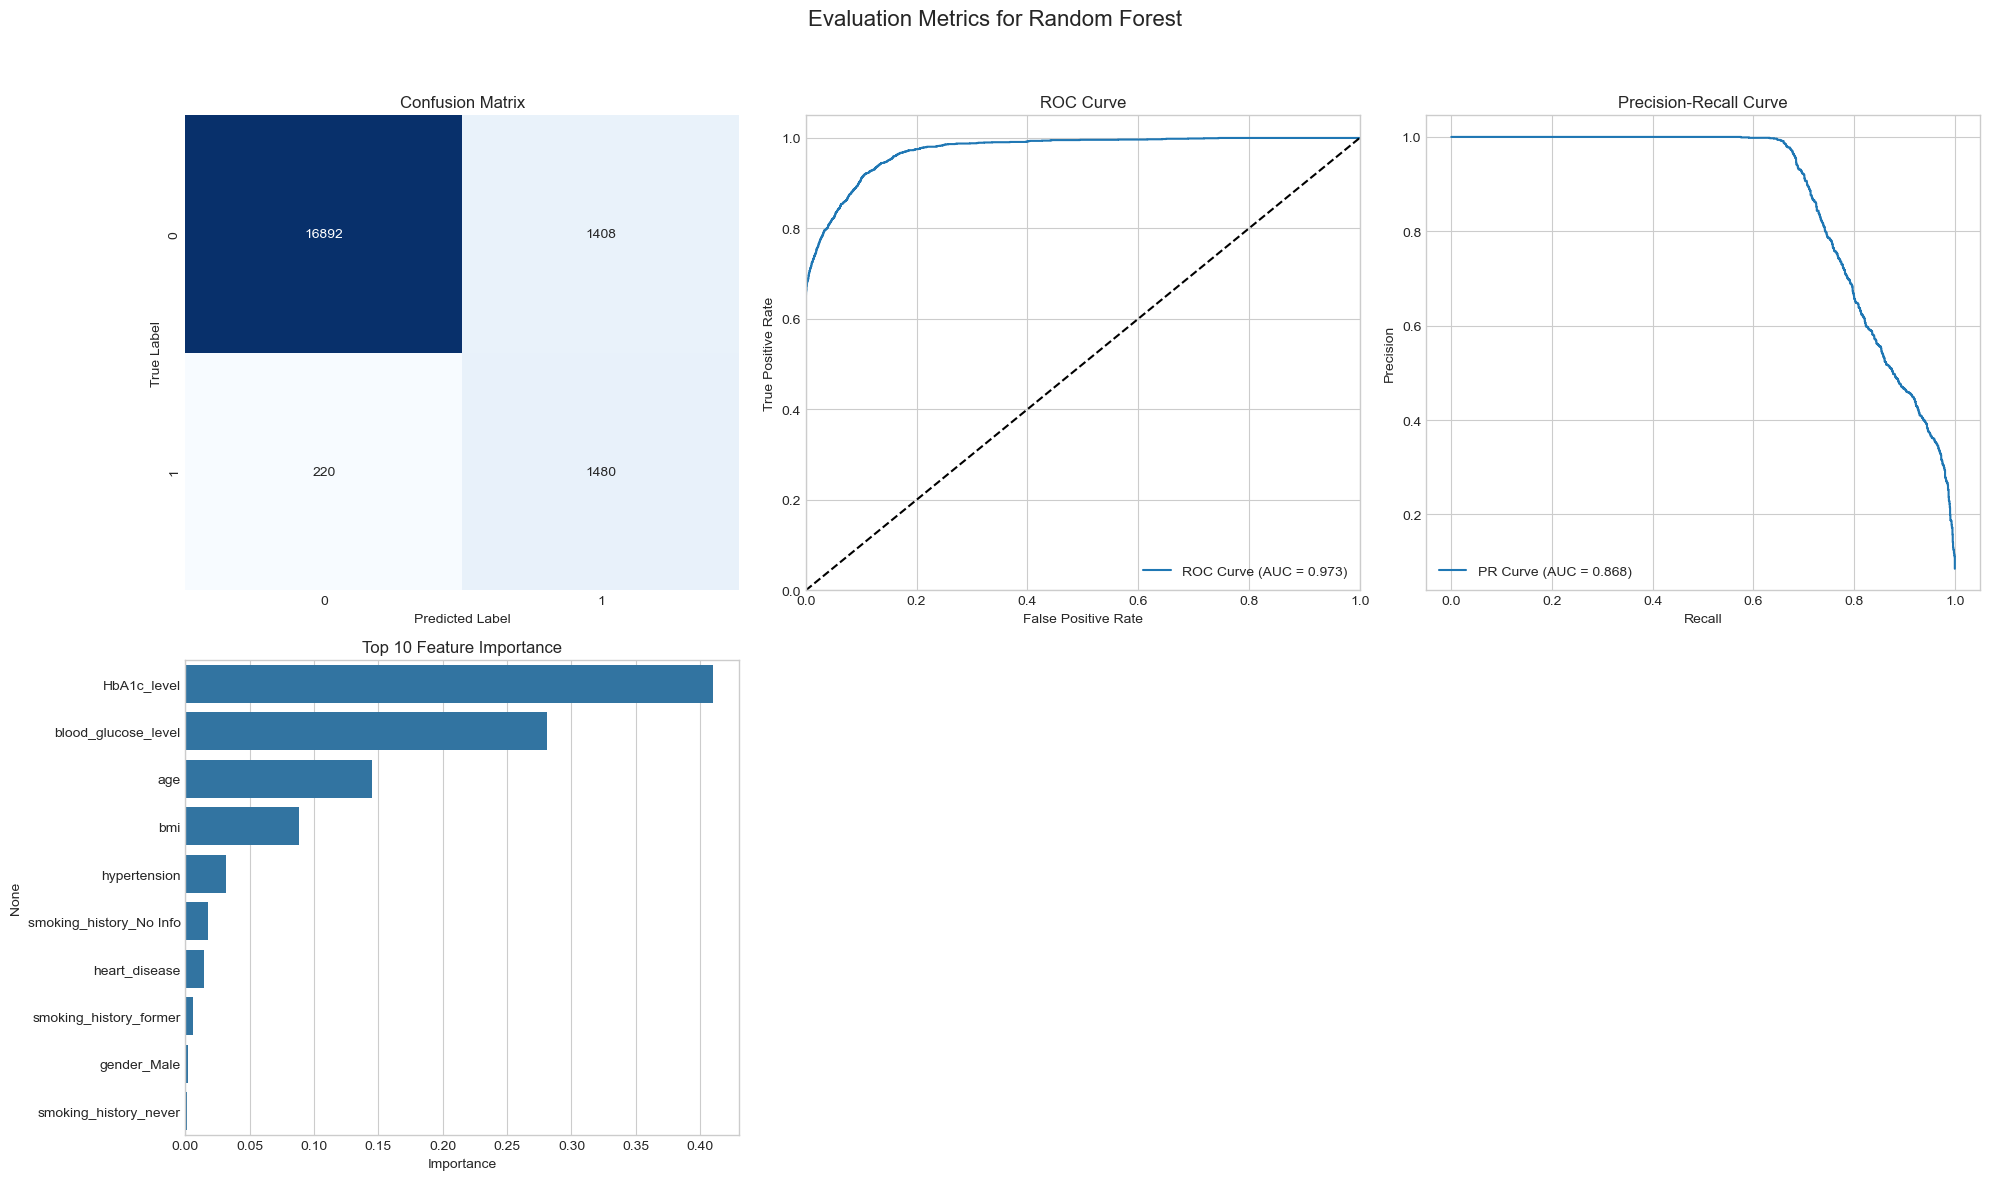


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.92      0.95     18300
           1       0.51      0.87      0.65      1700

    accuracy                           0.92     20000
   macro avg       0.75      0.90      0.80     20000
weighted avg       0.95      0.92      0.93     20000


=== XGBoost Model ===
Loading existing xgboost model from ..\models\kaggle_diabetes_xgboost_model.pkl...
Model loaded successfully!


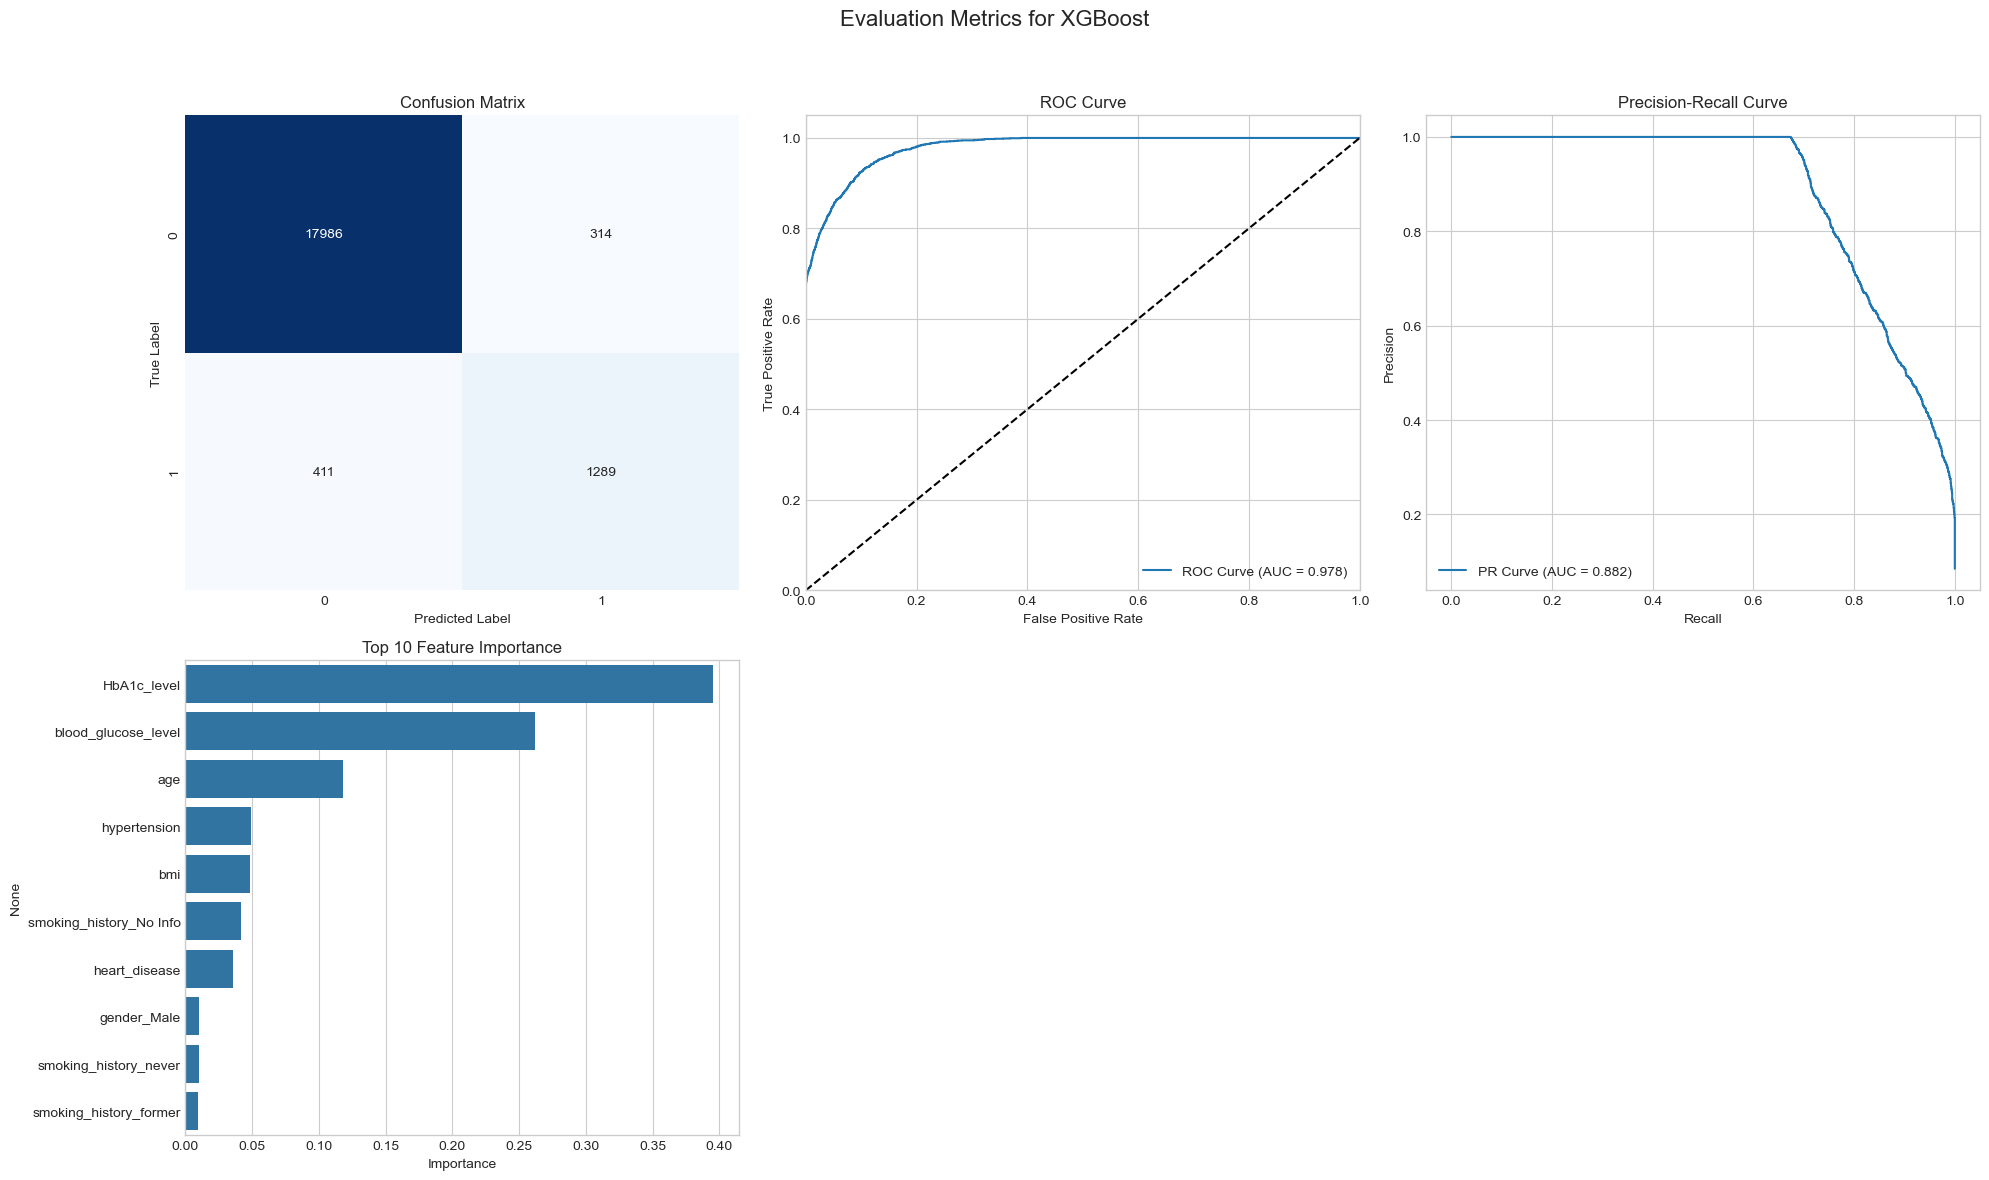


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     18300
           1       0.80      0.76      0.78      1700

    accuracy                           0.96     20000
   macro avg       0.89      0.87      0.88     20000
weighted avg       0.96      0.96      0.96     20000



In [45]:
model_results = {}

# Decision Tree (highest interpretability)
print("\n=== Decision Tree Model ===")
dt_model = train_or_load_model(
    X_train_processed, y_train, 
    model_type='decision_tree', 
    balance_method='smote',
    model_dir=MODEL_DIR,
    model_name=MODEL_NAME,
    force_retrain=FORCE_RETRAIN
)
dt_evaluation = evaluate_model(dt_model, X_test_processed, y_test, feature_names)
plot_evaluation_results(dt_evaluation, "Decision Tree")
model_results['decision_tree'] = {'model': dt_model, 'evaluation': dt_evaluation}

# Random Forest (balanced approach)
print("\n=== Random Forest Model ===")
rf_model = train_or_load_model(
    X_train_processed, y_train, 
    model_type='random_forest', 
    balance_method='smote',
    model_dir=MODEL_DIR,
    model_name=MODEL_NAME,
    force_retrain=FORCE_RETRAIN
)
rf_evaluation = evaluate_model(rf_model, X_test_processed, y_test, feature_names)
plot_evaluation_results(rf_evaluation, "Random Forest")
model_results['random_forest'] = {'model': rf_model, 'evaluation': rf_evaluation}

# XGBoost (highest performance)
print("\n=== XGBoost Model ===")
xgb_model = train_or_load_model(
    X_train_processed, y_train, 
    model_type='xgboost', 
    balance_method='smote',
    model_dir=MODEL_DIR,
    model_name=MODEL_NAME,
    force_retrain=FORCE_RETRAIN
)
xgb_evaluation = evaluate_model(xgb_model, X_test_processed, y_test, feature_names)
plot_evaluation_results(xgb_evaluation, "XGBoost")
model_results['xgboost'] = {'model': xgb_model, 'evaluation': xgb_evaluation}

In [46]:
performance_df = pd.DataFrame(columns=['Model', 'ROC AUC', 'PR AUC'])

for model_name, results in model_results.items():
    performance_df = performance_df._append({
        'Model': model_name,
        'ROC AUC': results['evaluation']['roc_auc'],
        'PR AUC': results['evaluation']['pr_auc']
    }, ignore_index=True)

performance_df = performance_df.sort_values('ROC AUC', ascending=False).reset_index(drop=True)
performance_df

,Model,ROC AUC,PR AUC
0,xgboost,0.978099,0.881950
1,random_forest,0.972574,0.868448
2,decision_tree,0.960288,0.866419


In [47]:
best_model_name = performance_df.iloc[0]['Model']
best_model = model_results[best_model_name]['model']
best_evaluation = model_results[best_model_name]['evaluation']

print(f"Best model: {best_model_name}")
print(f"ROC AUC: {best_evaluation['roc_auc']:.4f}")
print(f"PR AUC: {best_evaluation['pr_auc']:.4f}")

model_metadata = {
    'best_model': best_model_name,
    'model_comparison': performance_df.to_dict(orient='records'),
    'timestamp': pd.Timestamp.now().isoformat(),
    'best_roc_auc': float(best_evaluation['roc_auc']),
    'best_pr_auc': float(best_evaluation['pr_auc'])
}

with open(Path(MODEL_DIR) / f"{MODEL_NAME}_metadata.json", 'w') as f:
    json.dump(model_metadata, f, indent=4)

Best model: xgboost
ROC AUC: 0.9781
PR AUC: 0.8820


## 6. Model Interpretability with SHAP

In [48]:
explainer, shap_values = generate_shap_explanations(best_model, X_test_processed, feature_names, sample_size=100)

Generating SHAP values for 100 samples...


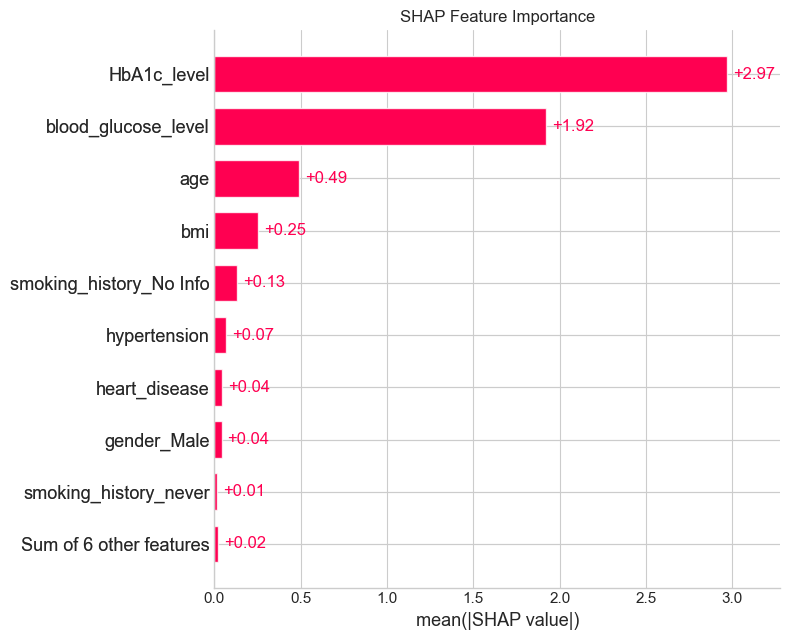

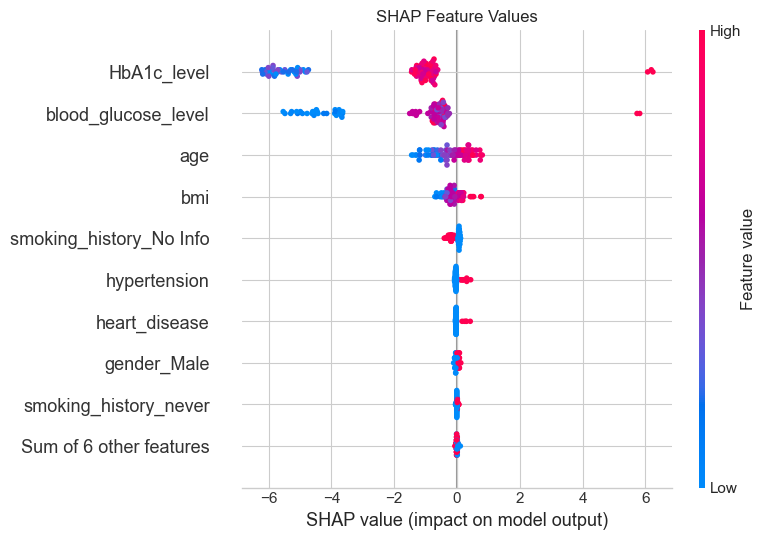

In [49]:
plot_shap_summary(shap_values, feature_names, plot_type="both")

SHAP values shape: (100, 15)
Features shape: (20000, 15)


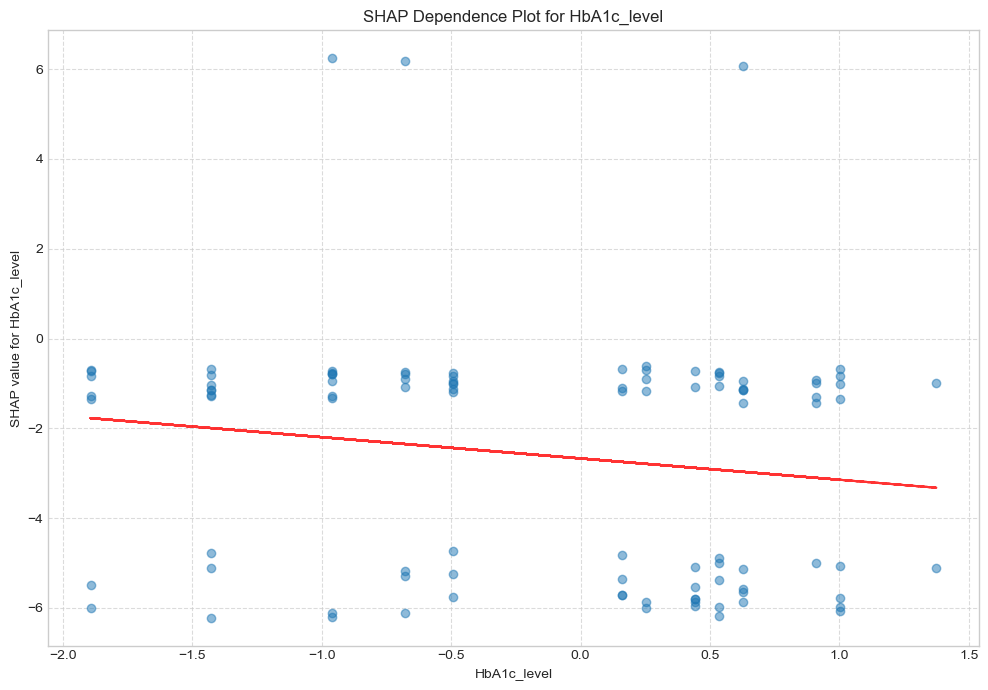

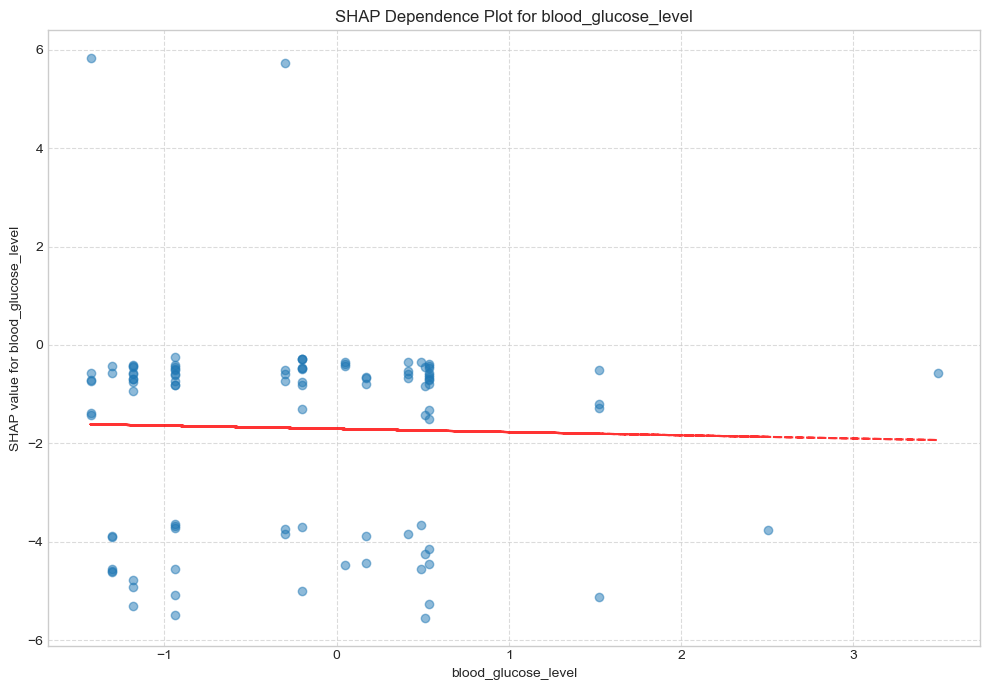

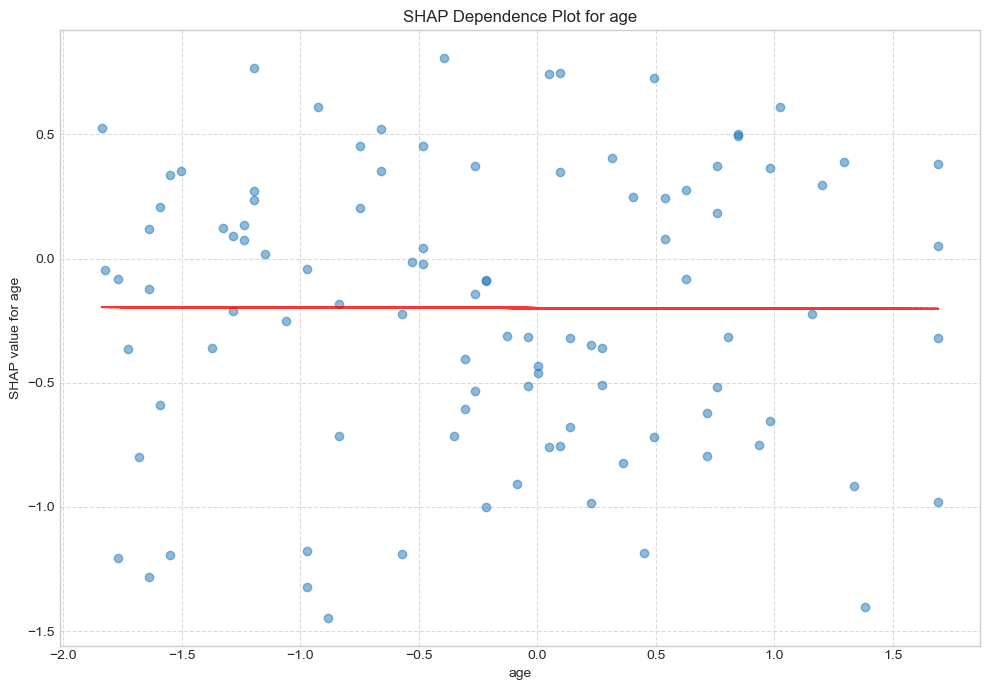

In [50]:
plot_shap_dependence(shap_values, X_test_processed, feature_names, top_n=3)

## 7. Healthcare Worker Dashboard

In [51]:
analyze_patient = create_healthcare_dashboard(
    best_model, preprocessor, feature_names, num_features, cat_features
)

Healthcare Dashboard created. Use analyze_patient() function to analyze patients.


Example Patient Data:
gender: Female
age: 36.0
hypertension: 0
heart_disease: 0
smoking_history: former
bmi: 22.64
HbA1c_level: 6.0
blood_glucose_level: 160
Prediction: Non-Diabetic (Probability: 0.05)
Risk Level: Low


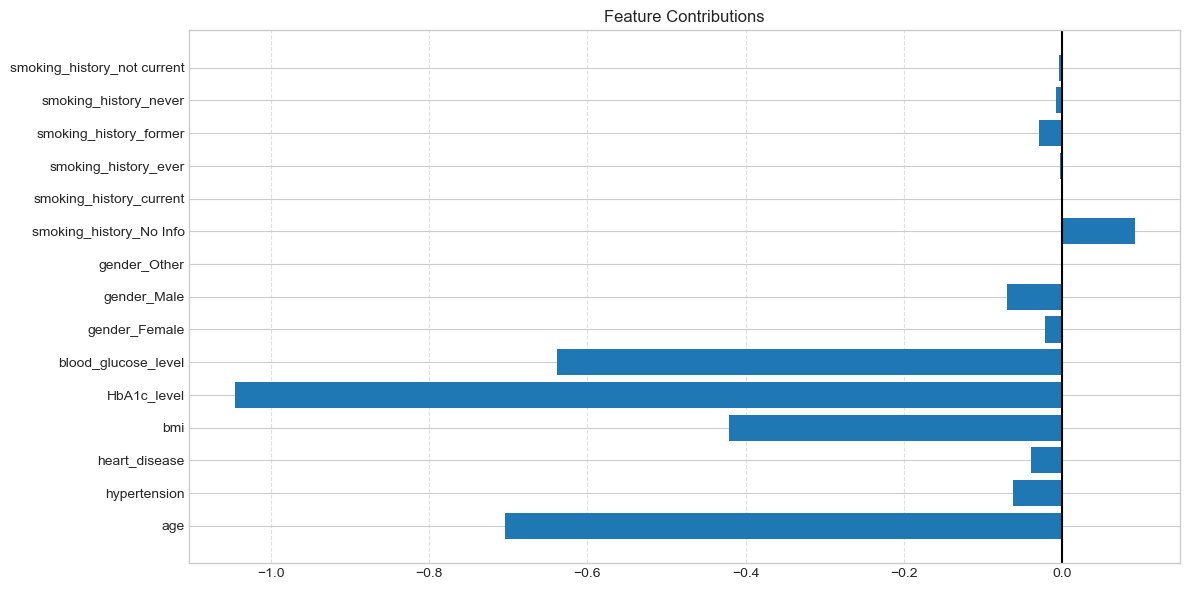


===== Risk Factor Analysis =====

Factors INCREASING diabetes risk:
  - smoking_history_No Info: 0.0925 contribution

Factors DECREASING diabetes risk:
  - HbA1c_level: -1.0463 contribution
  - age: -0.7045 contribution
  - blood_glucose_level: -0.6386 contribution


In [52]:
example_patient = X_test.iloc[[0]].copy()
print("Example Patient Data:")
for col in example_patient.columns:
    print(f"{col}: {example_patient[col].values[0]}")

patient_analysis = analyze_patient(example_patient)

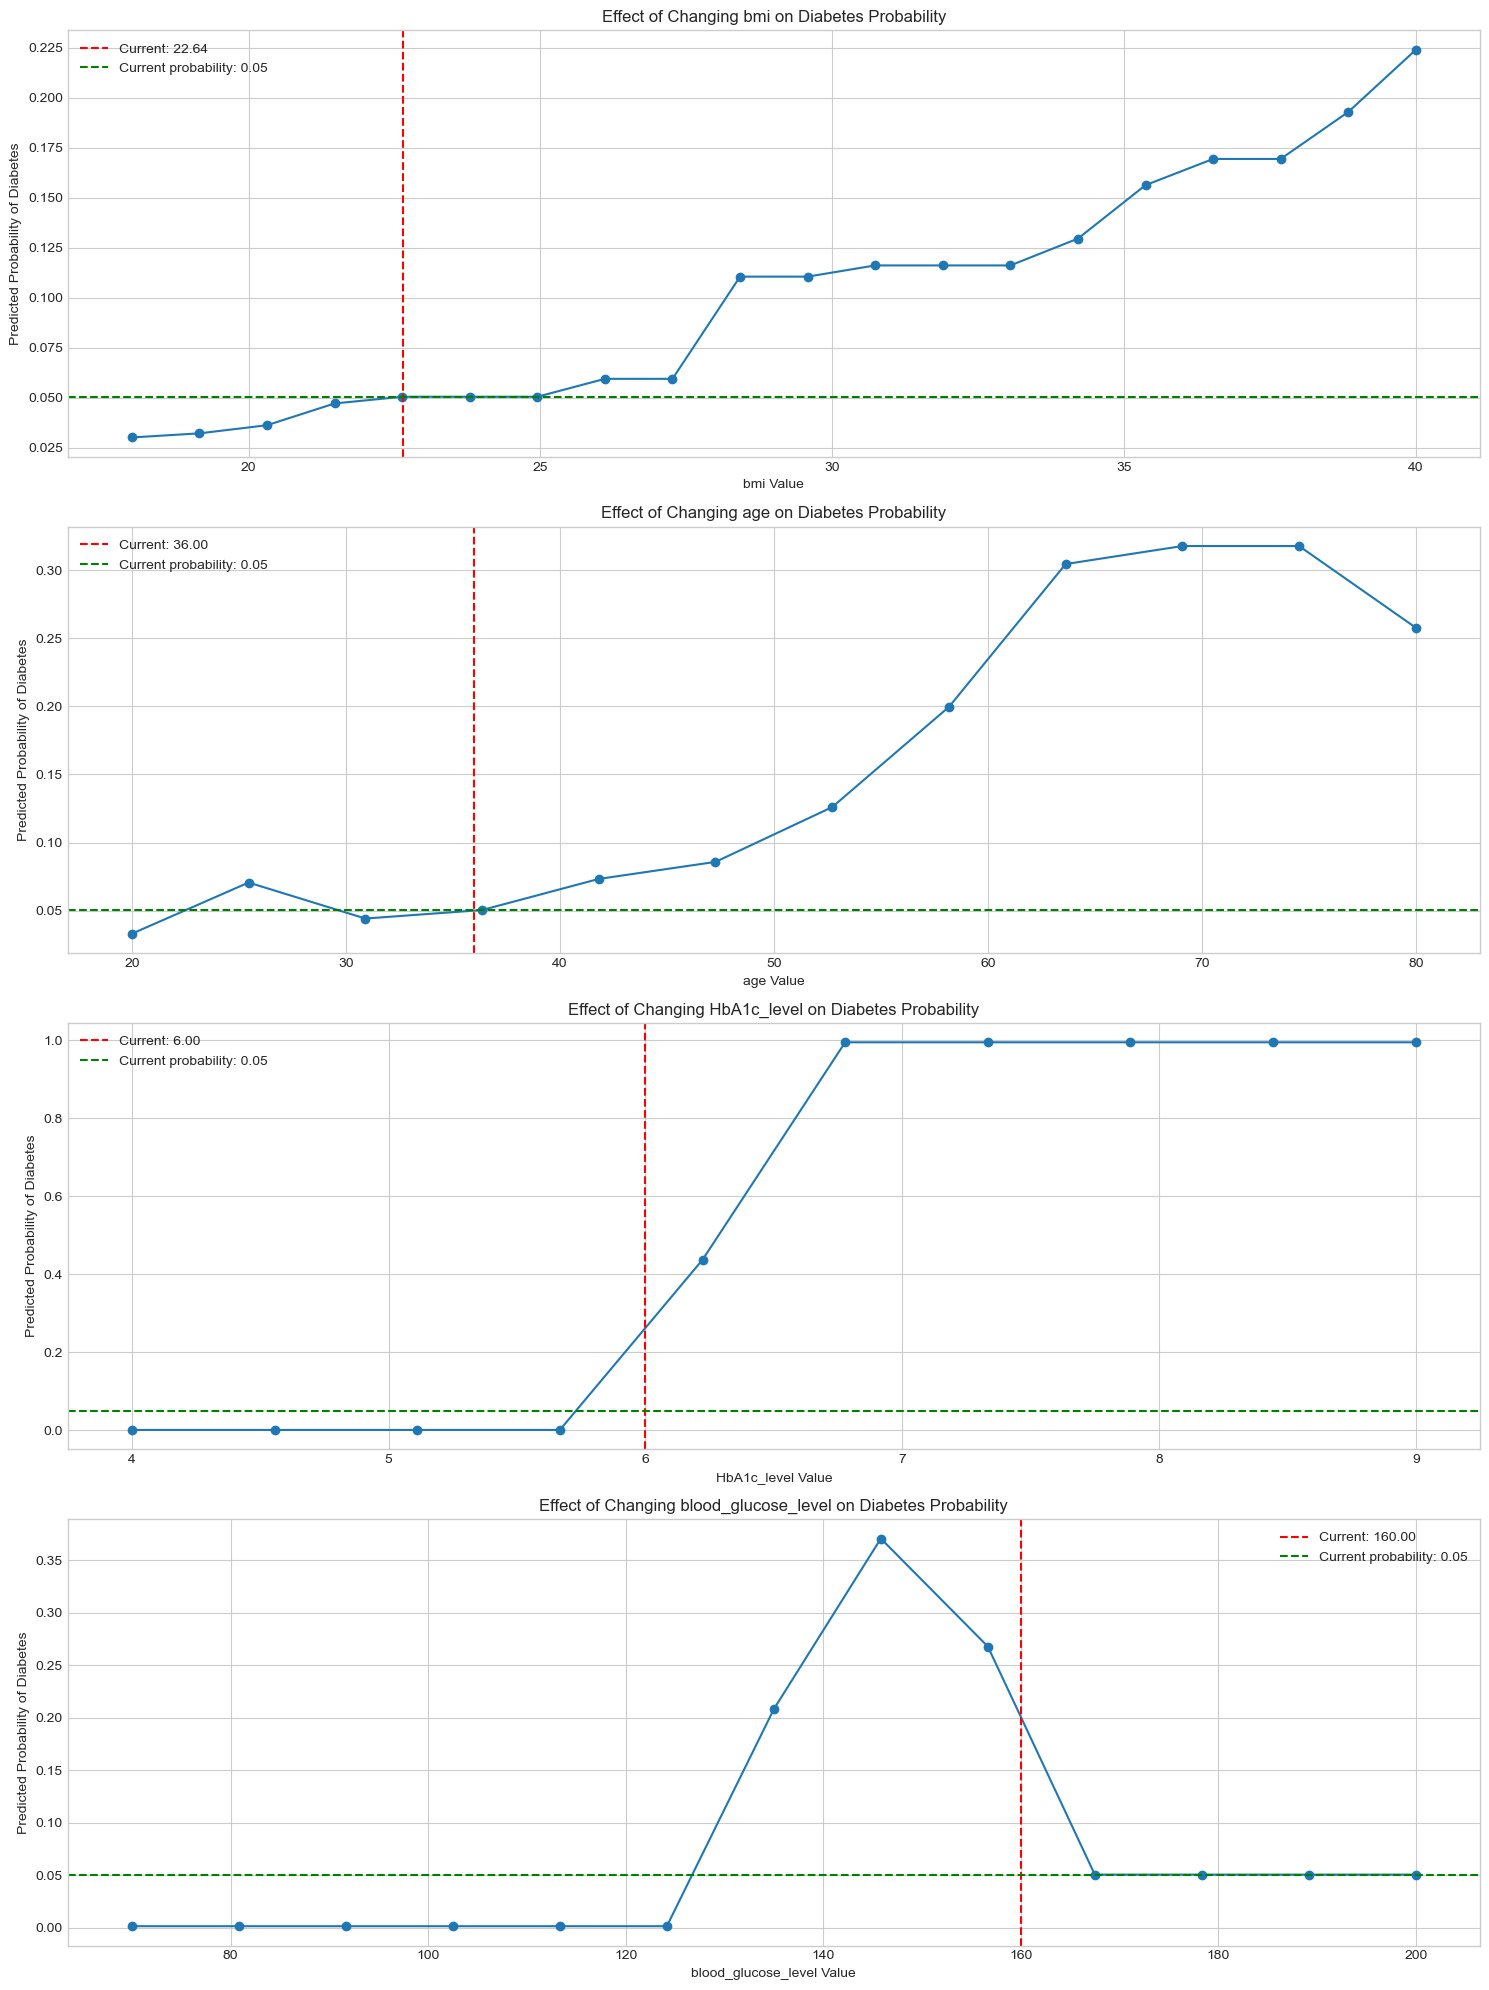

In [53]:
feature_ranges = {
    'bmi': (18, 40, 20),               # Range from 18 to 40 with 20 steps
    'age': (20, 80, 12),               # Age range from 20 to 80 with 12 steps
    'HbA1c_level': (4, 9, 10),         # HbA1c level range from 4 to 9 with 10 steps
    'blood_glucose_level': (70, 200, 13) # Blood glucose level from 70 to 200 with 13 steps
}

create_what_if_analysis(
    example_patient, best_model, preprocessor, num_features, feature_ranges
)

## 8. Save Model and Artifacts

In [54]:
save_model_artifacts(
    best_model,
    preprocessor,
    feature_names,
    num_features,
    cat_features,
    model_dir=MODEL_DIR,
    model_name=MODEL_NAME,
    model_metadata={
        'best_model': best_model_name,
        'timestamp': pd.Timestamp.now().isoformat(),
        'roc_auc': float(best_evaluation['roc_auc']),
        'pr_auc': float(best_evaluation['pr_auc']),
        'model_comparison': performance_df.to_dict(orient='records')
    }
)

print(f"Model training and evaluation complete. The best model ({best_model_name}) has been saved.")

Model artifacts saved to ..\models
Model training and evaluation complete. The best model (xgboost) has been saved.
